In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')
import datetime
import time

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd

# Main imports
import econml
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
from keras.optimizers import Adagrad

# EconML imports
from econml.dr import LinearDRLearner
from econml.iv.nnet import DeepIV
import keras
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference

import warnings
warnings.simplefilter('ignore')

In [2]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

# DGP constants
np.random.seed(1234)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
instrument=np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
# ORF parameters and test data
subsample_ratio = 0.4
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))


In [3]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(W.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

outcome_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(W.shape[1]+1,)),
                                  keras.layers.Dropout(0.17),
                                  keras.layers.Dense(64, activation='relu'),
                                  keras.layers.Dropout(0.17),
                                  keras.layers.Dense(32, activation='relu'),
                                  keras.layers.Dropout(0.17),
                                  keras.layers.Dense(1)])

keras_fit_options_1 = {"epochs": 200,
                      "validation_split": 0.20,
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
                      }
keras_fit_options_2 = {"epochs": 200,
                      "validation_split": 0.20,
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
                      }

deepIvEst = DeepIV(n_components = 15, 
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z,x])), 
                   h = lambda t, x : outcome_model(keras.layers.concatenate([t,x])),  
                   n_samples = 2, 
                   use_upper_bound_loss = True, 
                   n_gradient_samples = 0, 
                   optimizer= keras.optimizers.Adagrad(learning_rate=0.0009,),  
                   first_stage_options = keras_fit_options_2, 
                   second_stage_options = keras_fit_options_1
                   ) 

Epoch 1/200
25/25 [==============================] - 1s 15ms/step - loss: 0.2743 - val_loss: 0.2627
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2684 - val_loss: 0.2582
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2637 - val_loss: 0.2543
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2590 - val_loss: 0.2510
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2559 - val_loss: 0.2480
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2538 - val_loss: 0.2453
Epoch 7/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2488 - val_loss: 0.2429
Epoch 8/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2462 - val_loss: 0.2407
Epoch 9/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2443 - val_loss: 0.2386
Epoch 10/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2423 - val_loss: 0.2367
Epoch 11

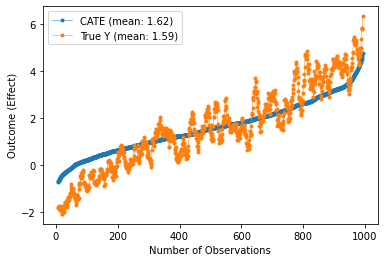

In [4]:
deepIvEst.fit(Y=Y,T=T,X=W,Z=instrument)

y_pred_per = deepIvEst.predict(T, W)
te_df_per = pd.DataFrame(y_pred_per, columns=['cate'])
te_df_per['true y']=Y
te_df_per.sort_values('cate', inplace=True, ascending=True)
te_df_per.reset_index(inplace=True, drop=True)
z_per = te_df_per.rolling(window=15, center=True).mean()

cate_mean=np.mean(te_df_per['cate'])
y_mean=np.mean(te_df_per['true y'])

plt.plot(z_per['cate'],
            marker='.', linestyle='-', 
            linewidth=0.5, 
            label='CATE (mean: '+str(round(cate_mean,2))+')', 
            )
plt.plot(z_per['true y'],
        marker='.', linestyle='-', 
            linewidth=0.5, 
            label='True Y (mean: '+str(round(y_mean,2))+')', 
            )
plt.ylabel('Outcome (Effect)')
plt.xlabel('Number of Observations')
plt.legend()
plt.show()

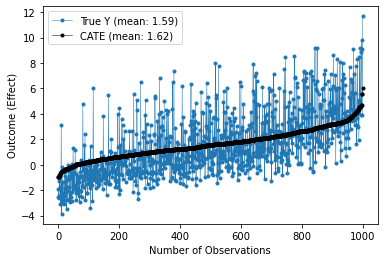

In [5]:
te_df_per = pd.DataFrame(y_pred_per, columns=['cate'])
te_df_per['true y']=Y
te_df_per.sort_values('cate', inplace=True, ascending=True)
te_df_per.reset_index(inplace=True, drop=True)
z_per = te_df_per.rolling(window=15, center=True).mean()

cate_mean=np.mean(te_df_per['cate'])

y_mean=np.mean(te_df_per['true y'])


plt.plot(te_df_per['true y'],
        marker='.', linestyle='-', 
            linewidth=0.5, 
            label='True Y (mean: '+str(round(y_mean,2))+')', 
            )

plt.plot(te_df_per['cate'],
            marker='.', linestyle='-', 
            linewidth=0.5, 
            label='CATE (mean: '+str(round(cate_mean,2))+')',color='black' 
            )
plt.ylabel('Outcome (Effect)')
plt.xlabel('Number of Observations')
plt.legend()
plt.show()

In [6]:
subsample_ratio=.3
lambda_reg = np.sqrt(np.log(W.shape[1]) / (10 * subsample_ratio * W.shape[0]))

In [7]:
est = DROrthoForest(
    n_trees=200, min_leaf_size=10,
    max_depth=30, subsample_ratio=subsample_ratio,
    propensity_model = LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
    model_Y = Lasso(alpha=lambda_reg),
    propensity_model_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
    model_Y_final=WeightedLasso(alpha=lambda_reg)
)

In [8]:
est.fit(Y, T, X=X, W=W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


In [9]:
# Calculate treatment effects for the default treatment points T0=0 and T1=1
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished


In [10]:
# Calculate default (95%) confidence intervals for the default treatment points T0=0 and T1=1
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


In [11]:
est2 = CausalForestDML(model_y=Lasso(alpha=lambda_reg),
                       model_t=LogisticRegression(C=1/(X.shape[0]*lambda_reg)),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50, max_samples=subsample_ratio/2,
                       discrete_treatment=True,
                       random_state=123)
est2.fit(Y, T, X=X, W=W, cache_values=True)
treatment_effects2 = est2.effect(X_test)
te_lower2, te_upper2 = est2.effect_interval(X_test)

In [12]:
est2.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate               
================================================================
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
     3.175       0.165 19.225    0.0         2.852         3.499
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    1.682           1.153           6.684
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       1.691           1.06          6.791
        Doubly Robust ATE on Training Data Results       
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATE          3.144   0.08 39.379    0.0    2.988    3.301
     Doubly Robust ATT(T=0) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          3.248  0.102 31.899    0.0    3.048    3.447
     Doubly Robust ATT(T=1) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          3.037  0.123 24.603    0.0    2.795    3.279
---------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

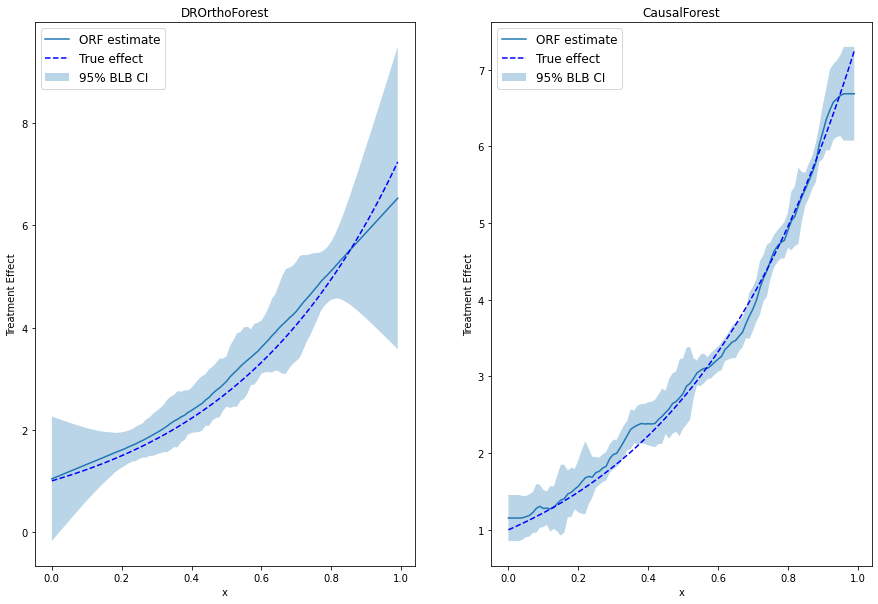

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title("DROrthoForest")
plt.plot(X_test, treatment_effects, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower, te_upper, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend(loc=2,prop={'size': 12})
plt.subplot(1, 2, 2)
plt.title("CausalForest")
plt.plot(X_test, treatment_effects2, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower2, te_upper2, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend(loc=2,prop={'size': 12})
plt.show()

In [14]:
ATE_for_cf=np.mean(expected_te)
ATE_for_cf

In [15]:
est = CausalForestDML(cv=2,
                      criterion='mse', n_estimators=400,
                      min_var_fraction_leaf=0.1,
                      min_var_leaf_on_val=True,
                      verbose=0, discrete_treatment=False,
                      n_jobs=-1, random_state=123)
%time est.fit(Y, T, X=X, W=W)

CPU times: total: 2.64 s
Wall time: 859 ms


In [16]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

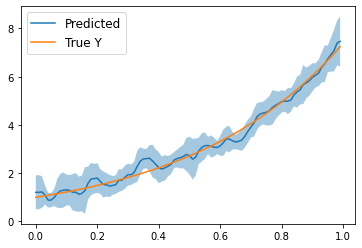

In [17]:
plt.plot(X_test[:, 0], point,label='Predicted')
plt.fill_between(X_test[:,0], lb, ub, alpha=.4)
plt.plot(X_test[:, 0],expected_te,label='True Y')
plt.legend(loc=2,prop={'size': 12})
plt.show()

In [18]:
res.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.206,0.274,4.399,0.0,0.669,1.743
1,1.206,0.274,4.399,0.0,0.669,1.743
2,1.222,0.256,4.778,0.0,0.721,1.724
3,1.096,0.155,7.068,0.0,0.792,1.400
4,0.883,0.120,7.366,0.0,0.648,1.117
...,...,...,...,...,...,...
95,6.743,0.214,31.453,0.0,6.323,7.163
96,6.912,0.272,25.404,0.0,6.379,7.445
97,7.082,0.335,21.113,0.0,6.425,7.740


In [19]:
res = est.effect_inference(X_test,
                           T0=np.zeros((X_test.shape[0],1)),
                           T1=np.ones((X_test.shape[0],1)))
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

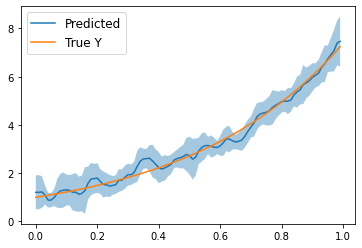

In [20]:
plt.plot(X_test[:, 0], point,label='Predicted')
plt.fill_between(X_test[:,0], lb, ub, alpha=.4)
plt.plot(X_test[:, 0],expected_te,label='True Y')
plt.legend(loc=2,prop={'size': 12})
plt.show()

In [21]:
##Constructing matrix for segmentation
res = est.effect_inference(X,
                           T0=np.zeros((X.shape[0],1)),
                           T1=np.ones((X.shape[0],1)))
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

causalforest=np.concatenate((lb.reshape(-1,1),ub.reshape(-1,1)),axis=1)
causalforest=np.concatenate((causalforest,point.reshape(-1,1)),axis=1)

In [22]:
total_frame=np.concatenate((causalforest,X.reshape(-1,1)),axis=1)
total_frame=np.concatenate((total_frame,W),axis=1)

In [23]:
total_frame

array([[ 1.4368949 ,  2.37340909,  1.90515199, ...,  0.12041429,
        -1.26864685,  0.52483734],
       [ 2.45062629,  3.58602606,  3.01832617, ..., -0.06375825,
         0.19689478, -0.11313818],
       [ 4.50870534,  5.43934065,  4.97402299, ..., -0.28872101,
        -0.27136977, -1.24925963],
       ...,
       [ 0.51840901,  1.98006717,  1.24923809, ...,  1.50157197,
         0.75391077, -0.05026632],
       [ 1.85633945,  3.18655585,  2.52144765, ...,  0.8634453 ,
         2.08342235, -1.1561219 ],
       [ 2.699756  ,  3.62171912,  3.16073756, ...,  0.70252456,
         0.85910352, -0.33335896]])

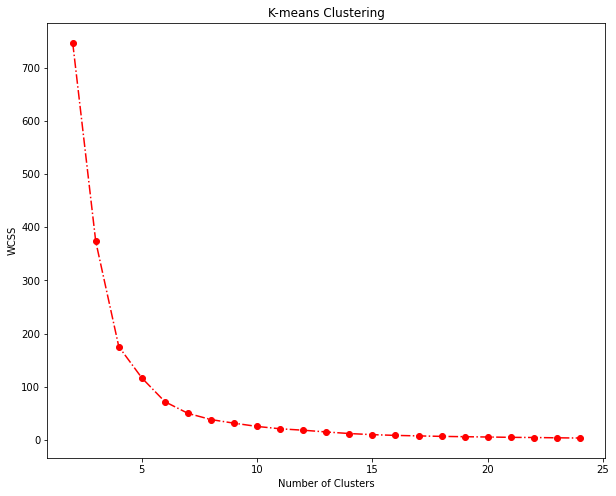

In [24]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np

wcss = []
hc_metrics=[]
hc_labels=[]
for i in range(2,25):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(point.reshape(-1,1))
    wcss.append(kmeans_pca.inertia_)
    
    kmeans = KMeans(n_clusters=i, random_state=1).fit(total_frame)
    # we store the cluster labels
    labels = kmeans.labels_
    hc_labels.append(labels)
    hc_metrics.append(metrics.calinski_harabasz_score(total_frame, labels))
    
plt.figure(figsize = (10,8))
plt.plot(range(2,25), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

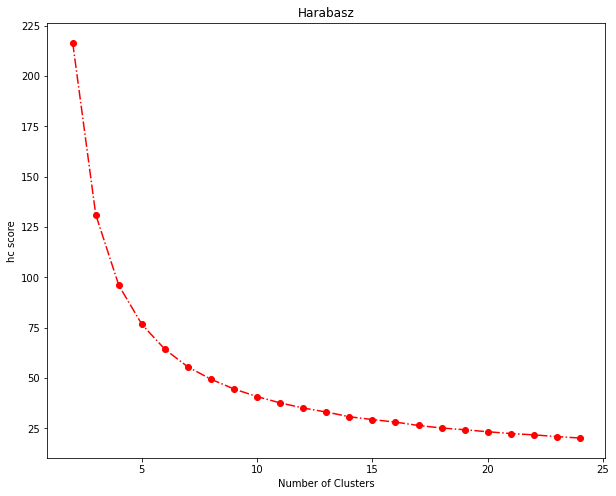

In [25]:
##Harabasz clusters hc score
plt.figure(figsize = (10,8))
plt.plot(range(2,25), hc_metrics, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('hc score')
plt.title('Harabasz')
plt.show()

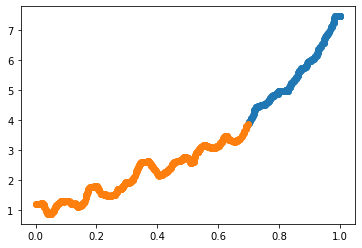

In [26]:
##Visualization of harabasz clusters for original dataset according
##to the treatment
for i in np.unique(hc_labels[np.argmax(hc_metrics)]):
    spots=np.where(hc_labels[np.argmax(hc_metrics)] == i)
    plt.scatter(total_frame[:,3][spots],total_frame[:,2][spots])

plt.show()